### Strain anisotropy

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

Using single station strain measurements to determine propagation direction and estimating wave velocities.

##### Simulation

Strain is the symmetric part of deformation. The anti-symmetric part is rotation. Strain is a tensor with six components.

$
\epsilon = \begin{pmatrix} \epsilon_{xx}&\epsilon_{xy}&\epsilon_{xz}\\\epsilon_{xy}&\epsilon_{yy}&\epsilon_{yz}\\\epsilon_{xz}&\epsilon_{yz}&\epsilon_{zz}\end{pmatrix}
$

with

$
\epsilon_{kl} = \frac{1}{2}(\partial_ku_l+\partial_ku_l)
$.

Consistent with using accelerations and rotation rates, both using combined spatial and temporal second derivatives, strain rates will be simulated rather than strain. Using plane waves and

$
u_{j,m} = An_{j,m}\exp(i\omega(t-\frac{\nu\cdot x}{v_m}))
$

where $\nu$ is the direction of propagation,$\omega$ the angular frequency, $m$ the wavetype (qP, qS1, qS2), $A$ some arbitrary scaling, $n_{jm}$ the j-th component of the m-th wavetype of the polarization. For each component of the strain rate follows

$
\dot\epsilon_{kl,m} = -\frac{A\omega^2}{2v_m}(\nu_kn_{l,m}+\nu_ln_{k,m})\exp(i\omega(t-\frac{\nu\cdot x}{v_m}))
$

##### Propagation direction

In an anisotropic medium, the propagation direction deviates from the polarization of the first arriving p-wave.
This makes the determination of the propagation direction with translational measurements only impossible. However, the information about the propagation direction is part of the definition of strain components. Therefore, if the polarization $n$ of the qP-wavefield is known, we could set up a system of equations.

$
\begin{pmatrix} \dot\epsilon_{xx}\\\dot\epsilon_{yy}\\\dot\epsilon_{zz}\\\dot\epsilon_{xy}\\\dot\epsilon_{xz}\\\dot\epsilon_{yz} \end{pmatrix} = -\frac{A\omega^2}{2v_{qP}}\begin{pmatrix} 2n_x&0&0\\0&2n_y&0\\0&0&2n_z\\n_y&n_x&0\\n_z&0&n_x\\0&n_z&n_y \end{pmatrix}\begin{pmatrix} \nu_x\\\nu_y\\\nu_z   \end{pmatrix}
$

or in short form

$
\epsilon = c N \nu
$.

The factor c provides scaling only and is unknown. We are interested in the normalized direction of propagation, so scaling doesn't affect our results.

We can solve for $\nu$.

$
\tilde\nu = (N^TN)^{-1}N^T\epsilon
$

and normalize it

$
\nu = \frac{\tilde\nu}{\vert\vert\tilde\nu\vert\vert}
$.

##### Velocity estimations

Knowing the propagation direction, all measurments can be rotated such that x-axis is parallel to it. As a result, multiple elements of the strain tensor are zero; diagonal elements $\epsilon_{yy}$ and $\epsilon_{zz}$ disappear as motions happen perpendicular to the yz-plane and the off-diagonal elements $\epsilon_{yz}$ is also set to zero.

Taking the ratios of acceleration and strain rate of specific wavefields in the direction of propagation, we get:

$m = qP$
$
\frac{\ddot u_x}{\dot\epsilon_{xx}} = \frac{-A\omega^2n_{x}}{-A\omega^2\nu_xn_{x}v^{-1}} = v
$
----
-----

$m = qS1$

$
\frac{\ddot u_{y}}{\dot\epsilon_{xy}} = \frac{-A\omega^2n_{y}}{-A\omega^2\nu_xn_{y}(2v)^{-1}} = 2v
$
----
----

$m = qS2$

$
\frac{\ddot u_{z}}{\dot\epsilon_{xz}} = \frac{-A\omega^2n_{z}}{-A\omega^2\nu_xn_{z}(2v)^{-1}} = 2v
$
----

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functions_anisotropy import *

In [2]:
def rotate_seis_strain(seis):
    nu = get_propagation_direction_strain(seis)
    theta, phi = get_angles(nu)
    nt = len(seis[0,:])
    R = np.zeros((3,3))
    r2d = 180/np.pi
    
    # Rodrigues' rotation formula, matrix will be rotated around vector r by angle pi 
    # x-axis=direction of propagation after rotation

    
    r = [(1. + np.cos(phi)*np.sin(theta))/2,\
         (np.sin(phi)*np.sin(theta))/2,\
         np.cos(theta)/2]
    r_sum = 0
    for i in range(0,3):
        r_sum += r[i]**2
    for i in range(0,3):
        r[i] = r[i]/np.sqrt(r_sum)
        
    K_sq = [[-r[1]**2-r[2]**2,r[0]*r[1],r[0]*r[2]], \
            [r[0]*r[1],-r[0]**2-r[2]**2,r[1]*r[2]], \
            [r[0]*r[2],r[1]*r[2],-r[0]**2-r[1]**2]]
    
    R[0,0] = 1 + 2*K_sq[0][0]
    R[1,0] = 2*K_sq[1][0]
    R[2,0] = 2*K_sq[2][0]

    R[0,1] = 2*K_sq[0][1]
    R[1,1] = 1 + 2*K_sq[1][1]
    R[2,1] = 2*K_sq[2][1]

    R[0,2] = 2*K_sq[0][2]
    R[1,2] = 2*K_sq[1][2]
    R[2,2] = 1 + 2*K_sq[2][2]

    seis_new = np.zeros((12,nt))
    
    for k in range(0,3):
        seis_new[k,:]   = R[k,0]*seis[0,:]+R[k,1]*seis[1,:]+R[k,2]*seis[2,:]
        seis_new[k+3,:] = R[k,0]*seis[3,:]+R[k,1]*seis[4,:]+R[k,2]*seis[5,:] 
        
    
    nang = 721
    xc  = np.zeros(nang)
    ang = np.linspace(0,180,nang)
    d2r = r2d**-1
    
    for i in range(nang):
        angle = ang[i]
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
        junk = np.corrcoef(xr, yr)
        xc[i] = junk[1,0]
        ang[i] = angle
        
    imax = np.argmax(xc)
    amax = ang[imax]
    
    angle = amax
    seis_new[1,:] = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
    seis_new[2,:] = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
    
    seis_new[4,:] = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
    seis_new[5,:] = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]
    
    #Rotating tensor
    R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
    R = np.dot(R,R2.transpose())
    RT = R.transpose()
    strain = np.zeros((len(seis[0,:]),3,3))
    strain_new = np.zeros((len(seis[0,:]),3,3))
    ws = []
    for i in range(0,len(seis[0,:])):
        a = abs(seis[6:,:].max())
        strain[i,:,:] = np.array([[seis[6,i],seis[9,i],seis[10,i]],[seis[9,i],seis[7,i],seis[11,i]],[seis[10,i],seis[11,i],seis[8,i]]])
        strain_new[i,:,:] = np.dot(RT,np.dot(strain[i,:,:],R))
        seis_new[6,i] = strain_new[i,0,0]
        seis_new[7,i] = strain_new[i,1,1]
        seis_new[8,i] = strain_new[i,2,2]
        seis_new[9,i] = strain_new[i,0,1]
        seis_new[10,i] = strain_new[i,0,2]
        seis_new[11,i] = strain_new[i,1,2]
    

    return seis_new, nu

In [3]:
def get_propagation_direction_strain(seis):
    n, _, _ = get_polarizations(seis[:3])
    e00, e11, e22, e01, e02, e12 = amplitude_first_peak(seis[6:]) 
    strain = np.array([e00,e11,e22,e01,e02,e12])
    N = np.array([[2*n[0],0,0],
                 [0,2*n[1],0],
                 [0,0,2*n[2]],
                 [n[1],n[0],0],
                 [n[2],0,n[0]],
                 [0,n[2],n[1]]])
    NT = N.transpose()
    nu_e_pre = np.dot(np.dot(np.linalg.inv(np.dot(NT,N)),NT),strain)
    nu_e = nu_e_pre / np.sqrt(nu_e_pre[0]**2+nu_e_pre[1]**2+nu_e_pre[2]**2)
    if nu_e[2]<0:
        nu_e = -nu_e
    return nu_e    

In [4]:
def estimate_velocities_strain(seis):
    qP = abs(max(seis[0,:],key=abs)/ max(seis[6,:],key=abs))
    qS1 = 0.5 * abs(max(seis[1,:],key=abs)/ max(seis[9,:],key=abs))
    qS2 = 0.5 * abs(max(seis[2,:],key=abs)/ max(seis[10,:],key=abs))
    if qS1 < qS2:
        qS1, qS2 = qS2, qS1
    return qP, qS1, qS2    

In [5]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [6]:
index = 1
C, density = get_specific_VTI(medium[index],give_thomsen=True)

taylor sandstone
 
vp0     = 3368
vs0     = 1829
eps     = 0.11
delta   = -0.035
gamma   = 0.255
density = 2500
 
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


x 1
y 1
z 1
Original data


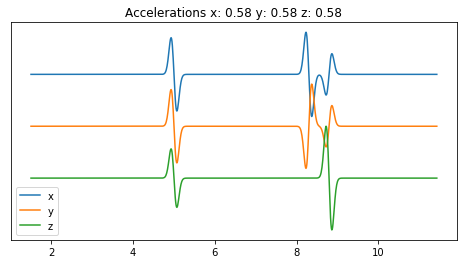

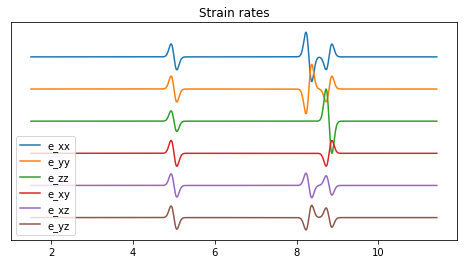

Rotated data


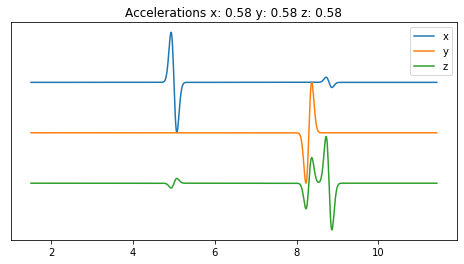

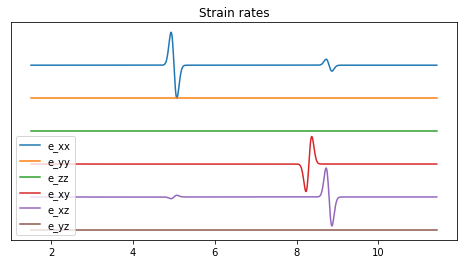

Estimated direction of propagation:
(0.9553166181245092, 0.7853981633974484)
Real direction of propagation:
(0.9553166181245092, 0.7853981633974483)
Estimated qP-velocity:
3515.4556073658373
Real qP-velocity:
3515.4556073658373
Estimated qS1-velocity:
2117.2205695203334
Real qS1-velocity:
2117.2205695203334
Estimated qS2-velocity:
1864.6113393382102
Real qS2-velocity:
1998.4841904070095
 


In [7]:
f = 10.
fs = 100.

nus, gammas = get_direction('input',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis_strain(v, vel, nus[0], f,fs)
print('Original data')
plotseis_strain(seis,t,nus[0])

seis_rot, nu_e = rotate_seis_strain(seis)
print('Rotated data')
plotseis_strain(seis_rot,t,nu_e)
qP, qS1, qS2 = estimate_velocities_strain(seis_rot)
vel_s = extract_slower_velocities(vel)

print('Estimated direction of propagation:')
print(get_angles(nu_e))
print('Real direction of propagation:')
print(get_angles(nus[0]))
print('Estimated qP-velocity:')
print(qP)
print('Real qP-velocity:')
print(max(vel))
print('Estimated qS1-velocity:')
print(qS1)
print('Real qS1-velocity:')
print(vel_s[0])
print('Estimated qS2-velocity:')
print(qS2)
print('Real qS2-velocity:')
print(vel_s[1])
print(' ')


C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:472: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


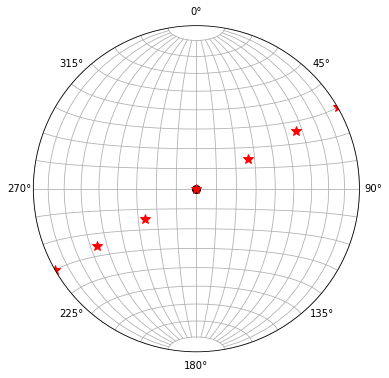

#0
Estimated direction of propagation:
(1.5707963267948966, 0.5235987755982988)
Real direction of propagation:
(1.5707963267948966, -2.617993877991495)
Estimated qP-velocity:
3720.0775905886694
Real qP-velocity:
3720.0775905886694
Estimated qS1-velocity:
1828.9999999999995
Real qS1-velocity:
2247.5128275496004
Estimated qS2-velocity:
1207.5877619968628
Real qS2-velocity:
1829.0
 
#1
Estimated direction of propagation:
(1.0265854383886073, 0.491627668545432)
Real direction of propagation:
(1.0471975511965979, -2.617993877991495)
Estimated qP-velocity:
4085.9811550629015
Real qP-velocity:
3561.8817017021047
Estimated qS1-velocity:
3273.804168330084
Real qS1-velocity:
2150.533813382156
Estimated qS2-velocity:
3155.2582829185803
Real qS2-velocity:
1968.077412877786
 
#2
Estimated direction of propagation:
(0.5185144648489195, 0.7424877740106114)
Real direction of propagation:
(0.5235987755982987, -2.617993877991495)
Estimated qP-velocity:
3894.980438852242
Real qP-velocity:
3369.1401639379

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1006: ComplexWarning: Casting complex values to real discards the imaginary part
  eigv[k] = v[:,l]


#5
Estimated direction of propagation:
(1.0471975511965974, 0.5235987755982987)
Real direction of propagation:
(1.0471975511965974, 0.5235987755982987)
Estimated qP-velocity:
3561.881701702105
Real qP-velocity:
3561.8817017021047
Estimated qS1-velocity:
1968.0774128777862
Real qS1-velocity:
2150.533813382158
Estimated qS2-velocity:
1810.058369586783
Real qS2-velocity:
1968.077412877786
 
#6
Estimated direction of propagation:
(1.5707963267948966, 0.5235987755982988)
Real direction of propagation:
(1.5707963267948966, 0.5235987755982987)
Estimated qP-velocity:
3720.077590588669
Real qP-velocity:
3720.0775905886694
Estimated qS1-velocity:
2247.5128275496013
Real qS1-velocity:
2247.512827549601
Estimated qS2-velocity:
1552.179225645354
Real qS2-velocity:
1829.0
 


In [8]:
N = 7
f = 10.

nus, gammas = get_direction('planar',C,N,phi_e=30.,theta_e=0.)
plot_directions(nus)
for i in range(0,N):
    vel,v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v, vel, nus[i], f, fs)

    seis_rot, nu_e = rotate_seis_strain(seis)
    qP, qS1, qS2 = estimate_velocities_strain(seis_rot)
    vel_s = extract_slower_velocities(vel)
    
    print('#'+str(i))
    print('Estimated direction of propagation:')
    print(get_angles(nu_e))
    print('Real direction of propagation:')
    print(get_angles(nus[i]))
    print('Estimated qP-velocity:')
    print(qP)
    print('Real qP-velocity:')
    print(max(vel))
    print('Estimated qS1-velocity:')
    print(qS1)
    print('Real qS1-velocity:')
    print(vel_s[0])
    print('Estimated qS2-velocity:')
    print(qS2)
    print('Real qS2-velocity:')
    print(vel_s[1])
    print(' ')